<a href="https://colab.research.google.com/github/surajn28/NMA-Transfer_Learning/blob/main/Transfer_learning_FER_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import os
import gc
import csv
import glob
import torch
import pandas as pd
import PIL
import h5py
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from google.colab import drive
from ResNet import ResNet,BasicBlock,Bottleneck

ModuleNotFoundError: ignored

Batch size: torch.Size([50, 3, 762, 562])


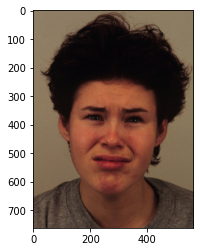

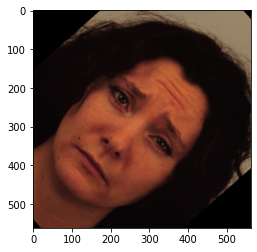

In [ ]:
# Data loader with data augmentation

class H5FileDataset(Dataset):
    # dataloader output: (pic_indices, color_channel, height, width)

    def __init__(self, h5_filename, transform=None, target_transform=None):
        self.h5_filename = h5_filename
        self.img_h5_file = self._load_h5_file(self.h5_filename)
        self.all_labels = self.img_h5_file['labels'][:]


    def __len__(self):
        return len(self.all_labels)


    def __getitem__(self, idx):
        img = self.img_h5_file['img_data'][idx]
        label = self.img_h5_file['labels'][idx]
        # sample = {'data': img,
        #           'label': label,
        #           'img_idx': idx}
        # img = img.transform([2, 0, 1])
        img = np.transpose(img, [2, 0, 1])
        img = img.astype(np.double)
        return img, label


    def _load_h5_file(self, h5_filename):
        file = h5py.File(h5_filename, 'r')
        img_data = file['pic_mat']
        img_labels = file['labels']
        # img_data.transpose((2, 0, 1))
        return dict(file=file, img_data=img_data, labels=img_labels)

kdef_test_dataset = H5FileDataset(r'drive/My Drive/datasets/KDEF_h5/kdef_test_dataset.h5')
test_dataloader = torch.utils.data.DataLoader(kdef_test_dataset, batch_size=50, shuffle=True)
batch_images, batch_labels = next(iter(test_dataloader))
print('Batch size:', batch_images.shape)
plt.figure()
plt.imshow(batch_images[0].to(torch.uint8).permute([1, 2, 0]).to(torch.uint8))
plt.show()

# transform_list = [transforms.RandomRotation(10)]
transform_list = [transforms.RandomRotation(90), transforms.CenterCrop([562, 562])]
aug = transforms.Compose(transform_list)

# aug = transforms.CenterCrop([64, 64])
for x, y in test_dataloader:
    # x = x.permute([0, 3, 1, 2])  # x: (idx, color_channel, height, width)
    x_aug = aug(x)
plt.imshow(x_aug[0].permute([1, 2, 0]).to(torch.uint8))

In [ ]:
from ResNet import ResNet,BasicBlock,Bottleneck
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 128
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
base_learning_rate = 0.1
torchvision_transforms = True  # True/False if you want use torchvision augmentations

def train(net, epoch, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()

    if batch_idx % 500 == 0:
      print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(net, acc, epoch, outModelName)
    return (test_loss/batch_idx, 100.*correct/total)

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

if __name__=="__main__":

    path = '/Users/gaojun/Documents/p1/NMA/FERG_DB_256'
    trainset = HDF5Dataset(osp.join(path,'train.h5'))
    testset = HDF5Dataset(osp.join(path,'test.h5'))

    trainloader = DataLoader(trainset, batch_size=12, shuffle=True)
    testloader = DataLoader(testset, batch_size=12, shuffle=True)

    net = ResNet18()
    net = net.double()


    result_folder = './results/'
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'

    # Optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

    outModelName = 'pretrain'
    if not os.path.exists(logname):
        with open(logname, 'w') as logfile:
            logwriter = csv.writer(logfile, delimiter=',')
            logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

    for epoch in range(start_epoch, max_epochs):
        adjust_learning_rate(optimizer, epoch)
        train_loss, train_acc = train(net, epoch, use_cuda=use_cuda)
        test_loss, test_acc = test(net, epoch, outModelName, use_cuda=use_cuda)
        with open(logname, 'a') as logfile:
            logwriter = csv.writer(logfile, delimiter=',')
            logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
        print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')

ModuleNotFoundError: ignored